In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
%matplotlib inline
from tqdm import notebook
import tensorflow as tf
from scipy import stats
from scipy.interpolate import interp1d

### simulate data

In [2]:
train=np.load('Train.npy')
test=np.load('Test.npy')

train_x=train[:,:-1]
train_y=train[:,-1].reshape(-1,1)

test_x=test[:,:-1]
test_y=test[:,-1].reshape(-1,1)

ntrain=len(train_x)
ntest=len(test_x)

### g-only, this is equivalent to using pre-training in under the Collaborating Network(CN) framework

In [3]:
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

In [4]:
 # Graph parameters
intermediate_layer_size = 100
intermediate_layer_size2 = 80
# Training parameters
batch_size = 100
pre_iter= ntrain*100

In [5]:
# g function learn the cdf
def g(yq,x):
    """
    yq:quantile:,
    x:input feature and treatment,
    """
    z1=tf.concat([yq,x],axis=1)
    hidden_layer = tf.compat.v1.layers.dense(z1, intermediate_layer_size,kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001), name="g1", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer_bn = tf.compat.v1.layers.batch_normalization(hidden_layer,name="g1bn")
    hidden_layer2 = tf.compat.v1.layers.dense(hidden_layer_bn, intermediate_layer_size2, kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001),name="g2", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer2_bn = tf.compat.v1.layers.batch_normalization(hidden_layer2,name="g2bn")
    gq_logit = tf.compat.v1.layers.dense(hidden_layer2_bn, 1,kernel_initializer=tf.initializers.glorot_normal, name="g3", activation=None,reuse=None)
    gq_logit_bn=tf.keras.layers.BatchNormalization(axis=-1,momentum=.1)(gq_logit)
    return gq_logit_bn

In [6]:
tf.compat.v1.disable_eager_execution()

In [7]:

tf.compat.v1.reset_default_graph()

# Placeholders
y_ = tf.compat.v1.placeholder(tf.float32, [None, 1])

pre_y= tf.compat.v1.placeholder(tf.float32, [None, 1])
x_=tf.compat.v1.placeholder(tf.float32, [None, test_x.shape[1]])
q_ = tf.compat.v1.placeholder(tf.float32, [None, 1])


ylessthan_pre= tf.cast(tf.less_equal(y_,pre_y),tf.float32)


with tf.compat.v1.variable_scope("g") as scope:
    gq_logit_pre = g(pre_y,x_)
    gq=tf.sigmoid(gq_logit_pre)*.99999+.00001




#pre-loss
g_loss_pre = tf.compat.v1.losses.sigmoid_cross_entropy(ylessthan_pre,gq_logit_pre)

# Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)
pre_step= optimizer.minimize(g_loss_pre,var_list=variables_from_scope("g"))


# Initializer
initialize_all = tf.compat.v1.global_variables_initializer()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


### Training

In [9]:
sess = tf.compat.v1.Session()
sess.run(initialize_all)
glpre=[]


for k in notebook.tnrange(pre_iter):
    i=np.random.randint(0,ntrain,batch_size)
    ytmp = train_y[i,:]
    xtmp= train_x[i,:]
    #when we do not have f initially, we use a uniform distribution to extract points from support
    pre_ytmp=np.random.uniform(-2,4.5,(batch_size,1))  
    ltmp,_=sess.run([g_loss_pre,pre_step],feed_dict={y_: ytmp,
                                x_:xtmp,
                                pre_y:pre_ytmp})
    
    glpre.append(ltmp)

    

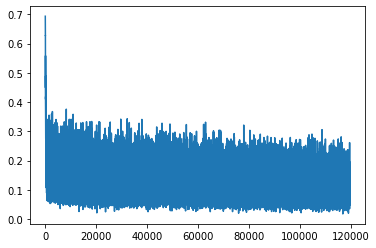

In [10]:
plt.plot(glpre)

### estimate calibration and likelihood

In [11]:
per=np.linspace(0.02,0.98,8)

In [12]:
low=np.quantile(test_y,0.05)
high=np.quantile(test_y,0.95)
itv=np.linspace(low,high,9)
itv=np.append(-np.infty,itv)
itv=np.append(itv,np.infty)
#outcome1 belongs to which interval
id=np.zeros(ntest)
for i in range(10):
    id=id+1*(test_y.ravel()>itv[i+1])
id=id.astype('int')


In [15]:
# estimation by g
med_est=np.array([]) #median
ll_est=np.empty(ntest)  #negative log likelihood
cal_est=np.zeros_like(per) #calibration

widthg=[] #interval width




#use interpolation to recover cdf
xtmp=np.linspace(-2,5,5000)


for i in notebook.trange(ntest):

    #cdf estimate by g
    cdf=sess.run(gq ,feed_dict={x_:np.tile(test_x[i,:],(5000,1)),
                                pre_y:xtmp[:,None]
                                }).ravel()

    invcdfest=interp1d(cdf,xtmp)
    cdfest=interp1d(xtmp,cdf)

    
      
    #estimate the ite
    med_est=np.append(med_est,invcdfest(0.5))    
    #estimate the loglikelihood
    l=itv[id[i]]
    r=itv[id[i]+1]


    if(r==np.inf):
        ll_est[i]=np.log(1.-cdfest(l)+1.e-10)
    elif(l==-np.inf):
        ll_est[i]=np.log(cdfest(r)+1.e-10)
    else:
        ll_est[i]=np.log(cdfest(r)-cdfest(l)+1.e-10)

    
    #estimate the calibration
    gl=invcdfest(0.5-per/2)
    gr=invcdfest(0.5+per/2)
    cal_est=cal_est+1.*(test_y[i]<gr)*(test_y[i]>gl)

    widthg.append(gr-gl)

cal_est=cal_est/ntest

In [16]:
cal_est

array([0.01002506, 0.11654135, 0.23182957, 0.34586466, 0.45864662,
       0.57894737, 0.73433584, 0.93483709])

In [17]:
np.abs(cal_est-per).mean()

0.07362155388471181

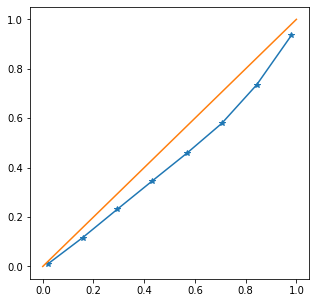

In [18]:
## calibration plot
plt.figure(figsize=(5,5))
plt.plot(per,cal_est,'-*')

plt.plot([0,1],[0,1])

In [19]:
# negative ll
ll_est.mean()

-1.5857351471676302

In [20]:
# mae
np.abs(test_y.ravel()-med_est).mean()

0.40883982575297834

In [21]:
# interval width
widthg=np.array(widthg)

wg_med=np.median(widthg,0)

wg_med

array([0.01367237, 0.10833858, 0.20908982, 0.32332177, 0.45913461,
       0.63469444, 0.9366943 , 2.14015311])

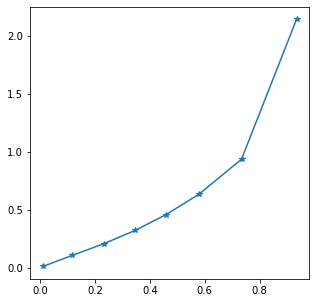

In [22]:
### sharpness plot
plt.figure(figsize=(5,5))
plt.plot(cal_est,wg_med,'-*')

#### calculate 90% interval width and coverage

In [24]:
width_est=np.empty(ntest)
cover_90=0


#use interpolation to recover cdf
xtmp=np.linspace(-2,4.5,5000)

for i in notebook.trange(ntest):
    #cdf estimate
    cdf=sess.run(gq ,feed_dict={x_:np.tile(test_x[i,:],(5000,1)),
                                pre_y:xtmp[:,None]
                                }).ravel()
    
     

    invcdfest=interp1d(cdf,xtmp)
    r=invcdfest(0.95)
    l=invcdfest(0.05)
    cover_90+=(test_y[i]<r)*(test_y[i]>l)
    width_est[i]=invcdfest(0.95)-invcdfest(0.05)




print(cover_90/ntest)


[0.80576441]
